# Predict

In [1]:
import sys
sys.path.append('..')
import os
import numpy as np
import argparse
import tensorflow as tf
import matplotlib.pyplot as plt
from segmentation.builders import model_builder, dataset_builder
from segmentation.utils import losses_utils, metrics_utils
from segmentation.datasets.deeplab_utils import get_dataset_colormap
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
tf.enable_eager_execution()

/home/ubuntu/anaconda3/envs/zyy_tf1.14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/zyy_tf1.14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/zyy_tf1.14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/zyy_tf

In [2]:
def parse_args():
    parser = argparse.ArgumentParser()

    # dataset
    parser.add_argument('--split_name', type=str, default="val", help='')
    
#     parser.add_argument('--dataset_name', type=str, default="pascal_voc_seg", help='')
#     parser.add_argument('--dataset_dir', type=str, default="/hdd02/zhangyiyang/data/VOCdevkit/segmentation_aug_tfrecords", help='')
#     parser.add_argument('--eval_crop_height', type=int, default=512)
#     parser.add_argument('--eval_crop_width', type=int, default=512)
#     parser.add_argument('--max_resize_value', type=int, default=512)
#     parser.add_argument('--min_resize_value', type=int, default=512)

#     parser.add_argument('--dataset_name', type=str, default="cityscapes", help='')
#     parser.add_argument('--dataset_dir', type=str, default="/hdd02/zhangyiyang/data/Cityscapes/tfrecords", help='')
#     parser.add_argument('--eval_crop_height', type=int, default=768)
#     parser.add_argument('--eval_crop_width', type=int, default=768)
#     parser.add_argument('--max_resize_value', type=int, default=768)
#     parser.add_argument('--min_resize_value', type=int, default=768)

    parser.add_argument('--dataset_name', type=str, default="camvid", help='')
    parser.add_argument('--dataset_dir', type=str, default="/hdd02/zhangyiyang/data/CamVid/tfrecords", help='')
    parser.add_argument('--max_resize_value', type=int, default=480)
    parser.add_argument('--min_resize_value', type=int, default=360)
    parser.add_argument('--eval_crop_height', type=int, default=480)
    parser.add_argument('--eval_crop_width', type=int, default=480)

    # model related
    parser.add_argument('--model_type', type=str, default="deeplab_v3_plus_v2")
    parser.add_argument('--backend_type', type=str, default="xception-deeplab")
    parser.add_argument('--model_weights', type=str, 
                       default="/hdd02/zhangyiyang/TF-Semantic-Segmentation/logs/logs-camvid-deeplab_v3_plus_v2_xception-deeplab-adam-lr_poly_0.0005-wd4e-05-new_loss/weights.40-0.44.hdf5"
                       )
    parser.add_argument('--output_stride', type=int, default=16)
    parser.add_argument('--fine_tune_batch_norm', action='store_true',
                        help='Whether to fine tune bach norm.')

    return parser.parse_args([])
args = parse_args()

In [3]:
def _get_datasets(args):
    val_dataset_configs = dataset_builder.build_dataset_configs(
        dataset_dir=args.dataset_dir,
        batch_size=1,
        crop_size=(args.eval_crop_height, args.eval_crop_width),
        max_resize_value=args.max_resize_value,
        min_resize_value=args.min_resize_value,
        should_shuffle=False,
        is_training=False,
        should_repeat=False,
    )
    val_dataset = dataset_builder.build_dataset(
        args.dataset_name, args.split_name, True, val_dataset_configs)

    return val_dataset

In [4]:
if not tf.executing_eagerly() and tf.__version__.split('.')[0] == "1":
    tf.logging.set_verbosity(tf.logging.INFO)
    tf_config = tf.ConfigProto()
    tf_config.gpu_options.allow_growth = True
    sess = tf.Session(config=tf_config)
    tf.keras.backend.set_session(sess)

dataset_meta = dataset_builder.build_dataset_meta(args.dataset_name)
val_dataset = _get_datasets(args)

In [5]:
keras_model = model_builder.build_model(
    model_type=args.model_type,
    backend_type=args.backend_type,
    weights=args.model_weights,
    num_classes=dataset_meta.num_classes,
    OS=args.output_stride,
    input_shape=(args.eval_crop_height, args.eval_crop_width, 3),
    fine_tune_batch_norm=args.fine_tune_batch_norm,
)

INFO:tensorflow:successfully load /hdd02/zhangyiyang/TF-Semantic-Segmentation/logs/logs-camvid-deeplab_v3_plus_v2_xception-deeplab-adam-lr_poly_0.0005-wd4e-05-new_loss/weights.40-0.44.hdf5 weights in /hdd02/zhangyiyang/TF-Semantic-Segmentation/logs/logs-camvid-deeplab_v3_plus_v2_xception-deeplab-adam-lr_poly_0.0005-wd4e-05-new_loss/weights.40-0.44.hdf5 for xception-deeplab


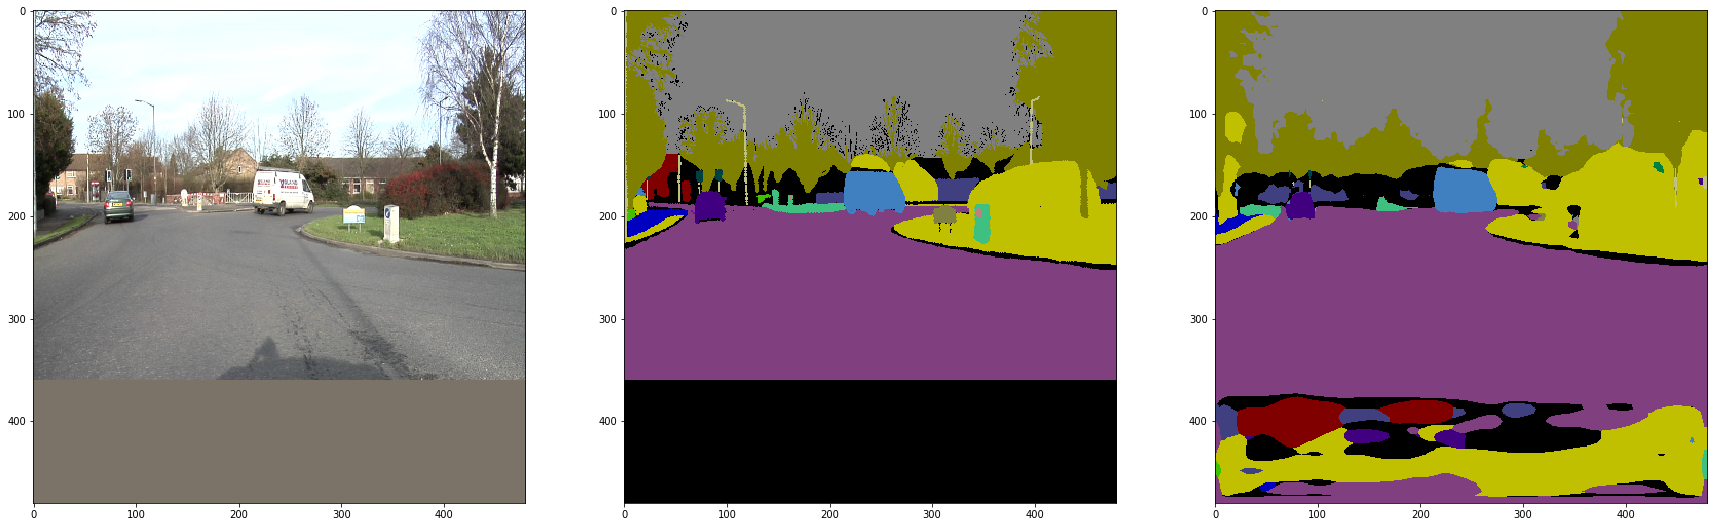

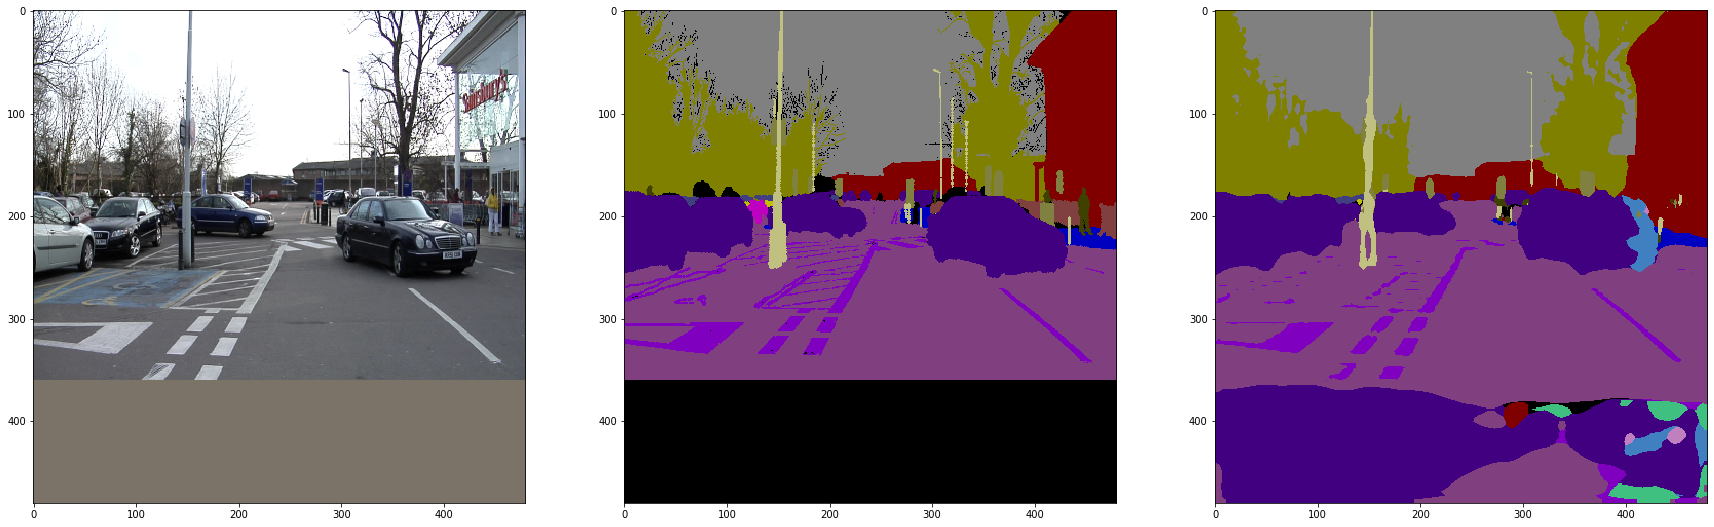

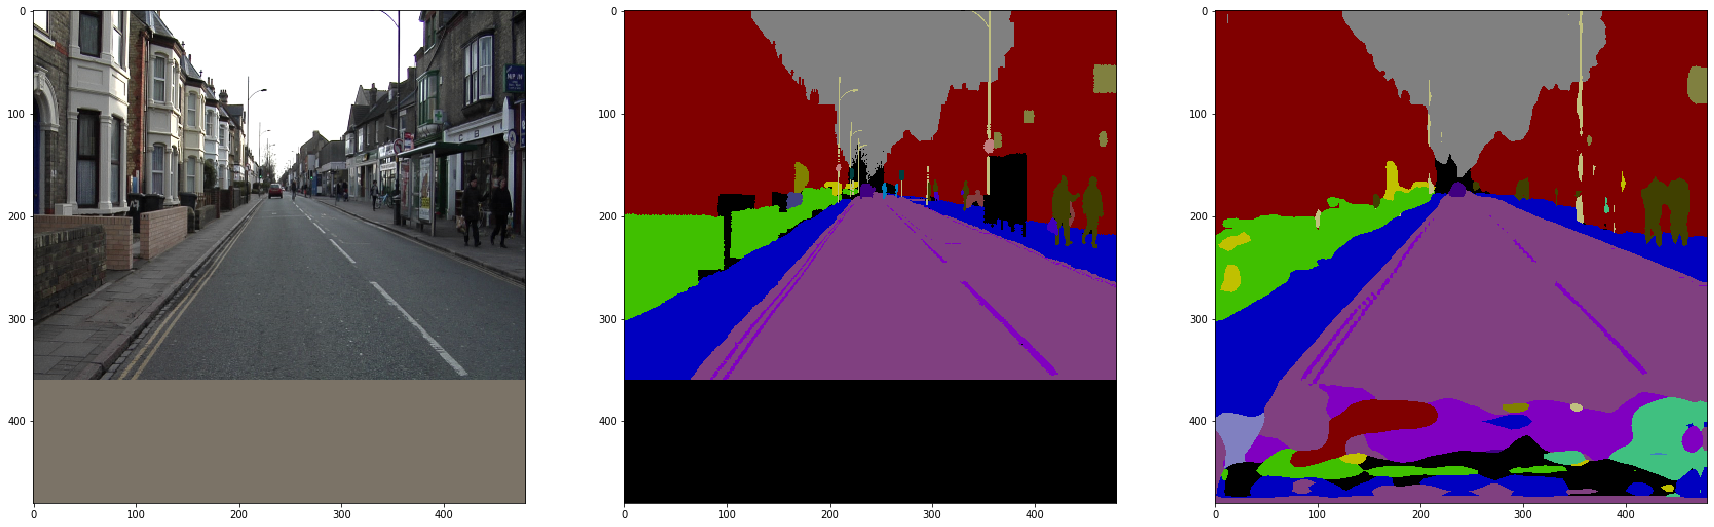

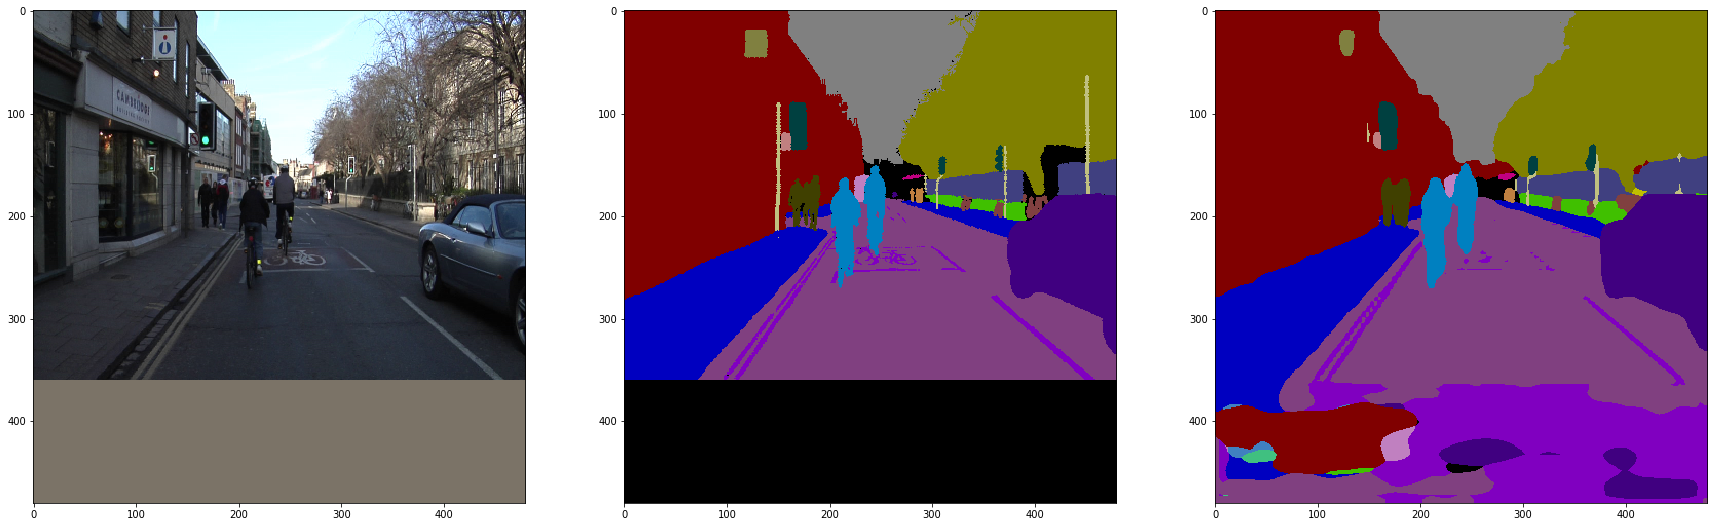

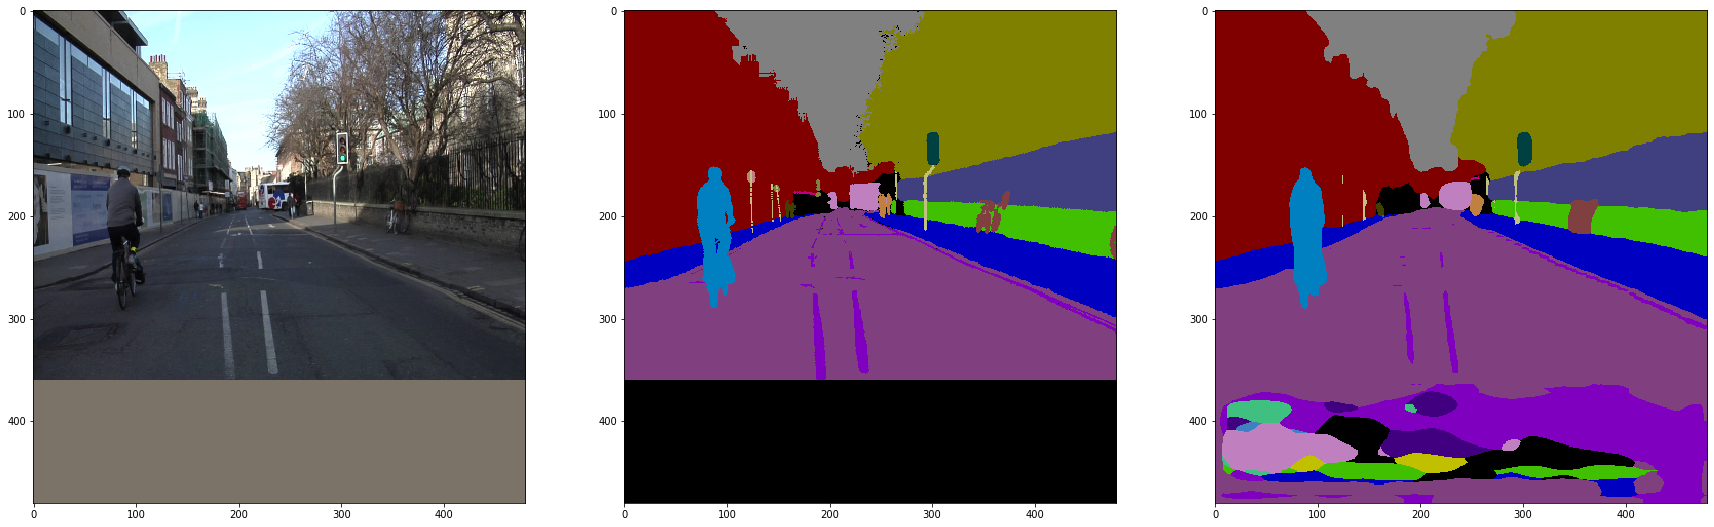

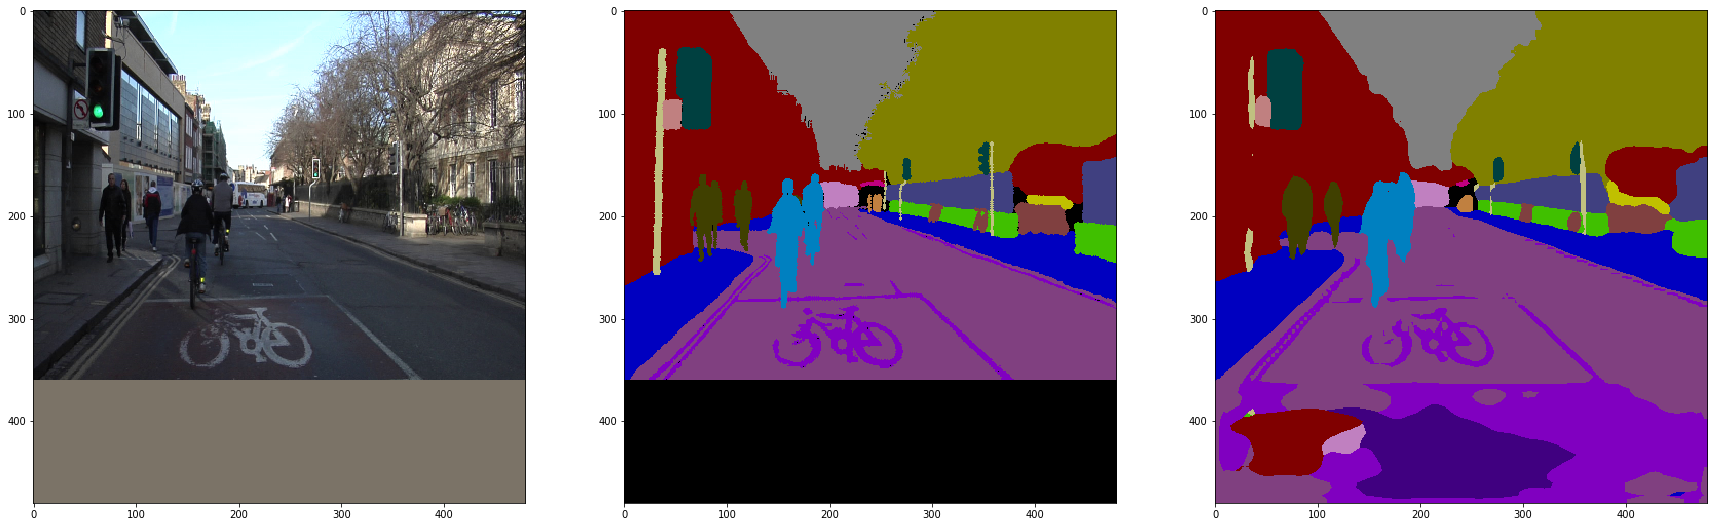

In [6]:
cnt = 0
for d in val_dataset:
    raw_img = d[0][0].numpy().astype(np.uint8)
    gt_color = get_dataset_colormap.label_to_color_image(d[1][0][:, :, 0], args.dataset_name)
    pred = keras_model.predict(d[0])
    pred = np.argmax(pred[0], axis=-1)
    pred_color = get_dataset_colormap.label_to_color_image(pred,args.dataset_name)
    
    
    fig = plt.figure(figsize=(30, 30))
    ax1 = fig.add_subplot(131)
    ax1.imshow(raw_img)
    ax2 = fig.add_subplot(132)
    ax2.imshow(gt_color)
    ax3 = fig.add_subplot(133)
    ax3.imshow(pred_color)
    
    cnt += 1
    if cnt > 5:
        break

In [7]:
np.bincount(d[1][0].numpy().reshape(-1))

array([    0,    99,  3633,     0, 33438,     0,     0,   201,  2032,
        5294,  5652,     0,     0,     0,  1801,     0,  2465, 46466,
           0, 14224,   518, 16580,     0,     0,  2893,     0, 32198,
         802,     0,   418,  1076,  3010,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [8]:
np.bincount(pred.reshape(-1))

array([    0,    54,  3930,     0, 38963, 13478,     0,   214,  1134,
        5049, 30844,     0,     0,     0,  1868,     0,  2484, 58898,
           0, 15111,   433, 17667,     0,     0,  2980,     0, 31605,
        1519,     0,   713,   476,  2980])